# Traj-XAI Basic Example

This notebook demonstrates the basic usage of the Traj-XAI package for explaining trajectory classifications.


## Setup

First, let's import the necessary libraries:


In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

In [2]:
import numpy as np
from pactus import Dataset
from pactus.models import LSTMModel
import matplotlib.pyplot as plt

# Import from our traj-xai package
from traj_xai.src import rdp_segmentation, gaussian_perturbation, TrajectoryManipulator

c:\Users\nickz\miniconda3\envs\traj_xai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\nickz\miniconda3\envs\traj_xai\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## Load and Prepare Data


In [3]:
# Set a random seed for reproducibility
SEED = 0

# Load the UCI Movement Libras dataset
# dataset = Dataset.uci_movement_libras()
dataset = Dataset.uci_pen_digits()
print(f"Dataset loaded: {len(dataset.trajs)} trajectories")

# Split data into train and test subsets
train, test = dataset.split(0.8, random_state=SEED)
print(f"Train set: {len(train.trajs)} trajectories")
print(f"Test set: {len(test.trajs)} trajectories")

Dataset loaded: 10992 trajectories
Train set: 8793 trajectories
Test set: 2199 trajectories


## Train a Black Box Model


In [4]:
# Build and train the model
model = LSTMModel(random_state=SEED)

# Train the model on the train dataset (with fewer epochs for demo)
model.train(train, dataset, epochs=5, batch_size=64)

# Evaluate the model on the test dataset
evaluation = model.evaluate(test)
evaluation.show()

19:24:15 [WARNING] Custom seed provided for lstm model. This calls 'tf.keras.utils.set_random_seed' which sets a global random state on python, numpy and tensorflow.
c:\Users\nickz\miniconda3\envs\traj_xai\lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\nickz\miniconda3\envs\traj_xai\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5187 - loss: 1.5251
Epoch 2/5
  9/138 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7683 - loss: 0.7853

c:\Users\nickz\miniconda3\envs\traj_xai\lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8469 - loss: 0.5218
Epoch 3/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9226 - loss: 0.2592
Epoch 4/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9529 - loss: 0.1572
Epoch 5/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9643 - loss: 0.1163
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

General statistics:

Accuracy: 0.946
F1-score: 0.945
Mean precision: 0.953
Mean recall: 0.944

Confusion matrix:

0      1      2      3      4      5      6      7      8      9      precision
98.69  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.47   0.0    99.56  
0.0    94.32  0.44   0.0    0.0    0.0    0.0    0.0    0.0    0.0    99.54  
0.0    3.06   97.82  0.0    0.0    0.0    0.0    0.0    0.0    0.0    96.97  
0.0    0.87   0.0    98.1   0.0    0.0    0.0    0.0    0.0    2.37   96.73  
0.44   0.44   0.0    0.0    99.56  0.47   0.95   0.0    3.32   0.0    95.0   
0.0    0.0    0.0    0.0    0.0    70.62 

## Visualize a Sample Trajectory


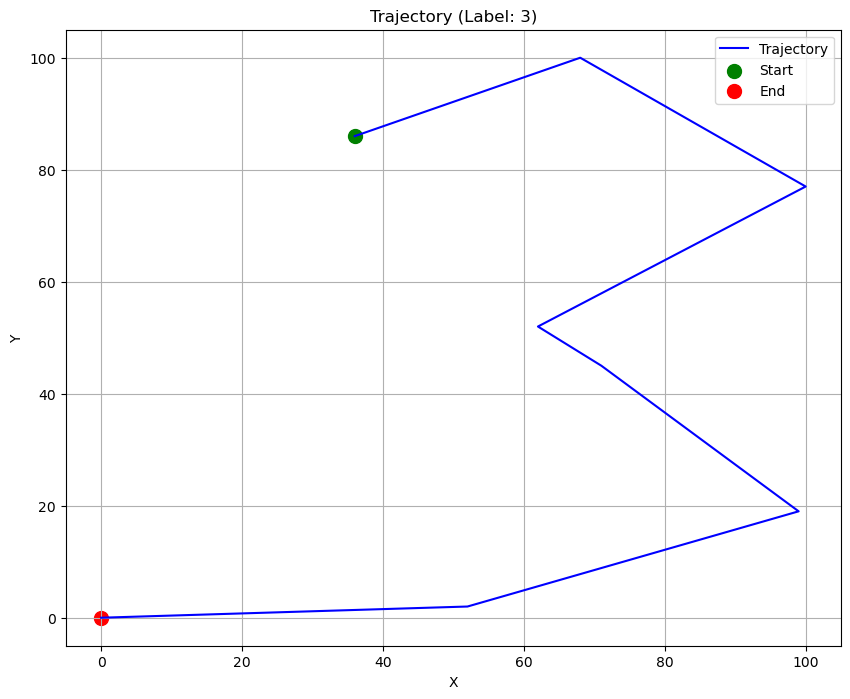

In [5]:
# Get a sample trajectory
sample_idx = 0
sample_traj = test.trajs[sample_idx]
sample_label = test.labels[sample_idx]

# Extract coordinates for plotting
points = sample_traj.r
x = [p[0] for p in points]
y = [p[1] for p in points]

# Plot the trajectory
plt.figure(figsize=(10, 8))
plt.plot(x, y, "b-", label="Trajectory")
plt.scatter(x[0], y[0], c="green", s=100, label="Start")
plt.scatter(x[-1], y[-1], c="red", s=100, label="End")
plt.title(f"Trajectory (Label: {sample_label})")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

## Segment the Trajectory


Number of segments: 8


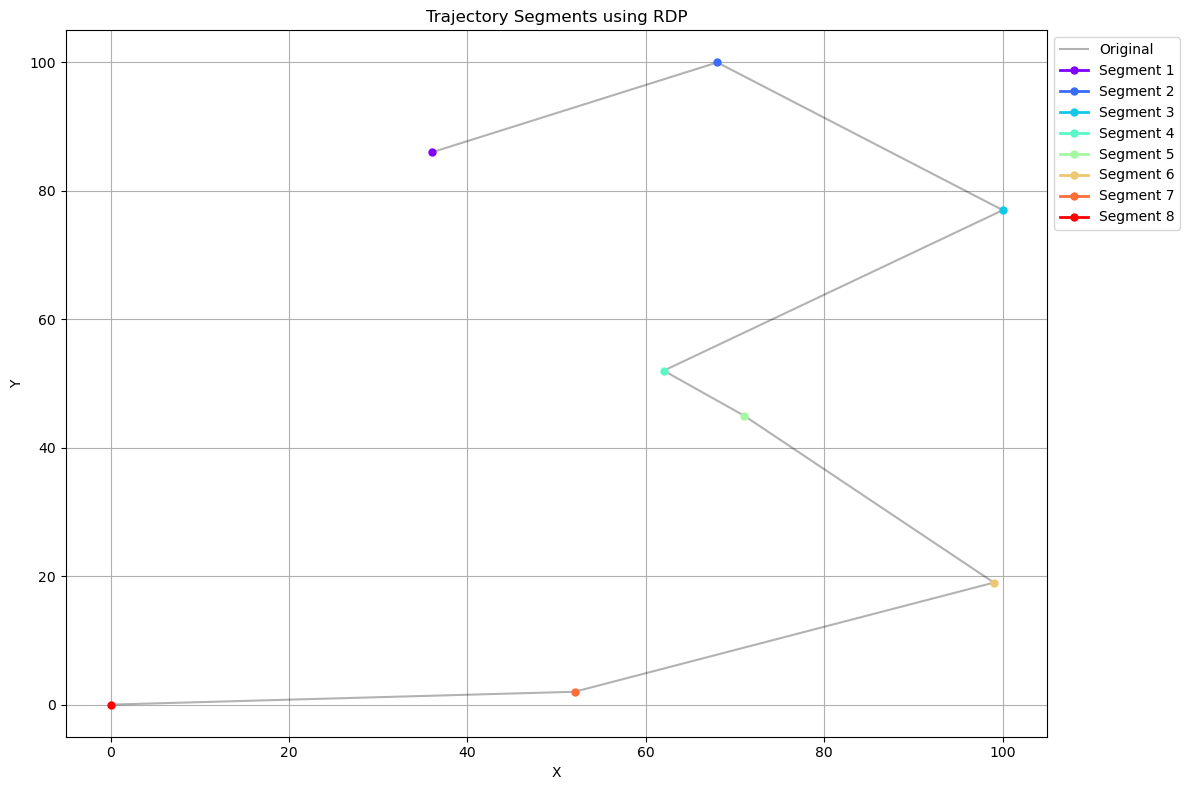

In [18]:
# Apply RDP segmentation
segments = rdp_segmentation(points, epsilon=0.01)
print(f"Number of segments: {len(segments)}")

# Plot the original trajectory and the segments
plt.figure(figsize=(12, 8))

# Plot original trajectory
plt.plot(x, y, "k-", alpha=0.3, label="Original")

# Plot each segment with a different color
colors = plt.cm.rainbow(np.linspace(0, 1, len(segments)))
for i, segment in enumerate(segments):
    segment_x = [p[0] for p in segment]
    segment_y = [p[1] for p in segment]
    plt.plot(segment_x, segment_y, ".-", color=colors[i], linewidth=2, markersize=10, label=f"Segment {i+1}")

plt.title("Trajectory Segments using RDP")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

## Perturb One Segment


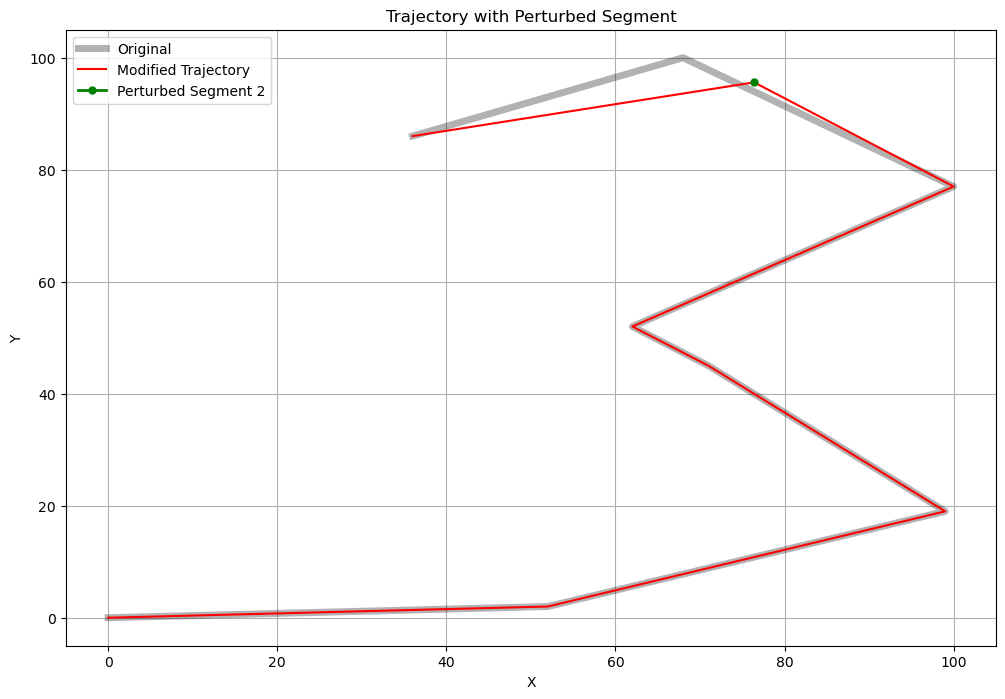

In [19]:
# Apply Gaussian perturbation to one segment
segment_to_perturb = 1  # Choose which segment to perturb
perturbed_segment = gaussian_perturbation(segments[segment_to_perturb])

# Visualize the perturbation
plt.figure(figsize=(12, 8))

# Plot original trajectory
plt.plot(x, y, "k-", alpha=0.3, lw=5, label="Original")

# Create a modified trajectory by replacing the perturbed segment
modified_segments = segments.copy()
modified_segments[segment_to_perturb] = perturbed_segment
modified_trajectory = []
for segment in modified_segments:
    modified_trajectory.extend(segment)

# Plot modified trajectory
modified_x = [p[0] for p in modified_trajectory]
modified_y = [p[1] for p in modified_trajectory]
plt.plot(modified_x, modified_y, "r-", label="Modified Trajectory")

# Highlight the perturbed segment
perturbed_x = [p[0] for p in perturbed_segment]
perturbed_y = [p[1] for p in perturbed_segment]
plt.plot(
    perturbed_x,
    perturbed_y,
    "g.-",
    linewidth=2,
    markersize=10,
    label=f"Perturbed Segment {segment_to_perturb+1}",
)

plt.title("Trajectory with Perturbed Segment")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

## Generate Explanation


In [21]:
# Create a TrajectoryManipulator for the sample trajectory
trajectory_explainer = TrajectoryManipulator(
    points, rdp_segmentation, gaussian_perturbation, model
)

# Get segments
segments = trajectory_explainer.get_segment()
print(f"Number of segments: {len(segments)}")

# Generate explanation
coef = trajectory_explainer.explain()
print(f"\nExplanation coefficients: {coef}")

if coef is not None:
    # Get the absolute values of coefficients for importance
    if len(coef.shape) > 1 and coef.shape[0] > 1:
        # For multi-class, take the row corresponding to the predicted class
        Y = trajectory_explainer.get_Y()[0]
        class_index = np.where(trajectory_explainer.classes_ == Y)[0][0]
        importances = np.abs(coef[class_index])
    else:
        importances = np.abs(coef[0])

    # Visualize segment importance
    plt.figure(figsize=(12, 8))

    # Plot the original trajectory
    plt.plot(x, y, "k-", alpha=0.3)

    # Plot each segment with color intensity based on importance
    normalized_importances = importances / importances.max()

    for i, segment in enumerate(segments):
        segment_x = [p[0] for p in segment]
        segment_y = [p[1] for p in segment]

        # Use red for positive influence, stronger color for higher importance
        color_intensity = normalized_importances[i]
        plt.plot(
            segment_x,
            segment_y,
            "-",
            color=(1.0, 0.0, 0.0, color_intensity),
            linewidth=2 + 3 * color_intensity,
        )

        # Add a text label for the segment importance
        mid_point = len(segment) // 2
        plt.text(
            segment_x[mid_point],
            segment_y[mid_point],
            f"{normalized_importances[i]:.2f}",
            fontweight="bold",
            ha="center",
            va="bottom",
        )

    plt.title("Segment Importance for Classification")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()


19:47:59 [DEBUG] Starting explanation process...


Number of segments: 8
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


19:47:59 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(256, 10)
19:47:59 [WARNING] Only one class detected, skipping explanation.



Explanation coefficients: None


## Evaluate the Effect of Perturbations


In [22]:
# Get predictions for evaluation trajectories
y_eval_sorted = trajectory_explainer.get_Y_eval_sorted()
y_eval_sorted_labels = trajectory_explainer._decode_labels(y_eval_sorted)
print("Predictions for evaluation trajectories (sorted by importance):")
for i, pred in enumerate(y_eval_sorted_labels):
    print(f"Segment {i+1}: {pred}")

# Get the original prediction
original_pred = trajectory_explainer.get_Y()
original_pred_label = trajectory_explainer._decode_labels(original_pred)
print(f"\nOriginal trajectory prediction: {original_pred_label}")

# Check if any segments change the classification when perturbed
changed_segments = []
for i, pred in enumerate(y_eval_sorted):
    if not np.allclose(pred, original_pred):  # Check if predictions differ
        changed_segments.append(i)

print(f"\nSegments that changed classification when perturbed: {changed_segments}")

19:48:08 [DEBUG] Starting get_Y_eval_sorted process...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


19:48:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(8, 10)
19:48:08 [DEBUG] Starting get_Y process...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


19:48:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1, 10)
19:48:08 [DEBUG] Finished get_Y_eval_sorted process.
19:48:08 [DEBUG] Starting get_Y process...


Predictions for evaluation trajectories (sorted by importance):
Segment 1: 3
Segment 2: 3
Segment 3: 3
Segment 4: 3
Segment 5: 3
Segment 6: 3
Segment 7: 3
Segment 8: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


19:48:08 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1, 10)



Original trajectory prediction: [3]

Segments that changed classification when perturbed: []
